In [4]:
import numpy as np
import scipy 
import matplotlib.pyplot as plt
import seaborn as sn
import pandas as pd
import ZebraLib as zb
import pyromat as pm
import CoolProp.CoolProp as CP

In [5]:
def K(C):
    return C+273.15

def MPa(psi):
    return psi*0.00689476

def get_air_properties(temperature):
    '''
    Temperature in K
    '''
    fluid = "Air"
    conductivity = CP.PropsSI("CONDUCTIVITY", "T", temperature, "P", 101325, fluid)
    viscosity = CP.PropsSI("VISCOSITY", "T", temperature, "P", 101325, fluid)
    prandtl = CP.PropsSI("PRANDTL", "T", temperature, "P", 101325, fluid)
    return conductivity, viscosity, prandtl

### Cáculando a taxa de transferência de calor

In [35]:
a, b = 0.08, 0.1   #elipse
r = (a+b)/2
Hbaixo, Halto = 0.08, 0.13 #alturas do óleos
H = Hbaixo + Halto
Lc = [r/2, Halto, Hbaixo]

def q_rad(Ts, T_pareds):
    #Radiação
    sig = 5.67E-8
    ep = 0.8
    q_rad = ep*sig*(Ts**4 - T_pareds**4)
    return q_rad

def q_conv(Ts, T_amb, Lc, verbose=False):
    #prop ar p/ temp de filme Tf
    Tf = (Ts + T_amb)/2
    k, v_ar, Pr = get_air_properties(Tf)

    def grashof():
        g = 9.81
        beta = 1/T_amb
        return (g*beta*(Ts - T_amb)*Lc**3)/v_ar**2

    #Convecção
    Ra_L = grashof()*Pr
    Nu = 0.59*Ra_L**(1/4)
    h = (Nu*k)/Lc
    q_conv = h*(Ts - T_amb) #W/m^2K

    if verbose:
        return grashof(), Ra_L, Nu, h, q_conv
    else:
        return q_conv

A =  np.array(([2*np.pi*r**2, 2*np.pi*r**2],  #considerando topo e base
                 [np.pi*r*Halto, np.pi*r*Halto],
                 [np.pi*r*Hbaixo, np.pi*r*Hbaixo]))
   
Tc = K(np.array(([74, 74], 
                 [64, 66],
                 [70, 73])))  

Ta = K(np.array(([25, 29], 
                 [25, 29],
                 [25, 29])))  

Tp = K(np.array(([23.5, 23.5], 
                 [23, 31],
                 [23.5, 31])))  


q_c = np.zeros_like(Ta)
q_r = np.zeros_like(Tp)

gra, Ra, Nu, h = np.zeros_like(Tp), np.zeros_like(Tp), np.zeros_like(Tp), np.zeros_like(Tp)

for i in range(3):
    for j in range(2):
        func = q_conv(Tc[i, j], Ta[i, j], Lc[i], 1)
        q_c[i, j] = func[4]*A[i, j]
        gra[i,j], Ra[i,j], h[i,j] = func[0], func[1], func[3]

        q_r[i, j] = q_rad(Tc[i, j], Tp[i, j])*A[i, j]

gra, Ra, h

(array([[ 381969.45520753,  342873.8384858 ],
        [7508140.02825408, 6927757.3346796 ],
        [1989899.51187593, 1888142.67615795]]),
 array([[ 269073.62200975,  241461.69405021],
        [5293052.94612258, 4881642.93267487],
        [1402182.32533279, 1329782.5814438 ]]),
 array([[8.37505515, 8.19350802],
        [6.02628161, 5.95218512],
        [7.08091555, 7.05127307]]))

In [37]:
print(f'Troca por convecção {q_c.sum():.2f}W')
print(f'Troca por Radiação { q_r.sum() :.2f}W')
print(f'Troca total {q_c.sum() + q_r.sum() :.2f}W')

Troca por convecção 70.61W
Troca por Radiação 60.04W
Troca total 130.65W


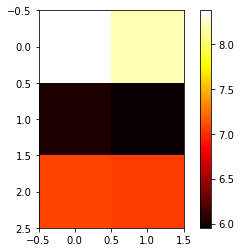

In [47]:
plt.imshow(h, cmap='hot', interpolation='nearest')
plt.colorbar()  # Adicione uma barra de cores para indicar os valores
plt.show()

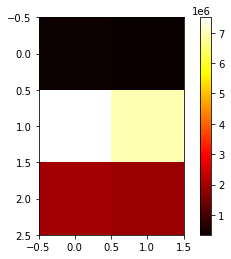

In [45]:
plt.imshow(gra, cmap='hot', interpolation='nearest')
plt.colorbar()  # Adicione uma barra de cores para indicar os valores
plt.show()

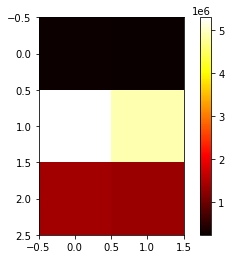

In [46]:
plt.imshow(Ra, cmap='hot', interpolation='nearest')
plt.colorbar()  # Adicione uma barra de cores para indicar os valores
plt.show()

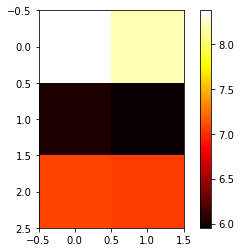

In [ ]:
#crit = (35*H)/grashof(Tm)**(1/4)
#Nu = (0.825 + ((0.387*(Ra_L)**(1/6))/(1+((0.492/Pr)**(9/16)))**(8/27)))**2 
#Nu = 0.1*Ra_L**(1/3)

#ELIPSE
#A_elip = np.pi*b*a
#P_elip = 2*np.pi*np.sqrt((b**2+a**2)/2)

'''#CILINDRO
r = (b+a)/2
A_base = np.pi*r**2    #área base
P_base = 2*np.pi*r     #perimetro
Lc = (H+r)             #comprimento caract
A_total =  P_base*(H) + 2*A_base 

Al_baixo = P_base*H1
Al_cima  = P_base*H1 + A_base

#dados do ar em volta do compressor
T_amb1, T_amb2 = 57, 63
T_ambt = 30

#Dados do compressor
T1, T2 = 62, 68
Tt, Tb = 70, None
T_amb = K(28)          #média do ambiente 
Tm = K((T1+T2+Tt)/3)   #média sup do compressor
Tf = (Tm + T_amb)/2 #temp de filme'''

In [ ]:
#prop ar a 47°C
k, v_ar, Pr = get_air_properties(Tf)

Ra_L = grashof(Tm)*Pr

print(f'Número de grashof é {grashof(Tm):.2e} --- Eq 9-15')
print(f'Número de Rayleigh é {Ra_L:.2e} --- usar correlação 9-19')
print(f'Critério para aprox pra placa {2*r:.2f}>={crit:.2f} tab 9-1 --> pode aprox pra placa vertical')

Nu = 0.59*Ra_L**(1/4)
h = (Nu*k)/Lc
print(f'Logo o h é {h:.2f} W/m^2k')

NameError: name 'Tf' is not defined

In [ ]:
#conveccão
Q_conv = A_total*h*(Tm - T_amb)

#radiação
sig = 5.67E-8
alpha, G, ep= 0.8, 0, 0.6
Q_rad = (alpha*G + ep*sig*(Tm**4 - T_amb**4))*A_total

Q_total = Q_conv+Q_rad
print(f'O calor por convecção soma {Q_conv:.2f}W')
print(f'O calor por radiação é {Q_rad:.2f}W')
print(f'O calor total trocado é {Q_total:.2f}W')
print(f'Contribuição convecção {(Q_conv/Q_total)*100:.2f}% e radiação {(Q_rad/Q_total)*100:.2f}%')

O calor por convecção soma 23.94W
O calor por radiação é 21.84W
O calor total trocado é 45.79W
Contribuição convecção 52.29% e radiação 47.71%
